In [1]:
x=1

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import decoupler as dc

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
sc.set_figure_params(vector_friendly=True, figsize=(4,4))

In [4]:
# adata = sc.read('../../pipeline/data/multigrate_mil_reg/pbmc_mtg_final1/old_7a87db1eef_adata_both.h5ad')
adata = sc.read('../../../pipeline/data/multigrate_mil_reg/pbmc_mtg_final1/d31255f30e_adata_both.h5ad')
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn'
    obsm: 'X_umap', 'latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4'

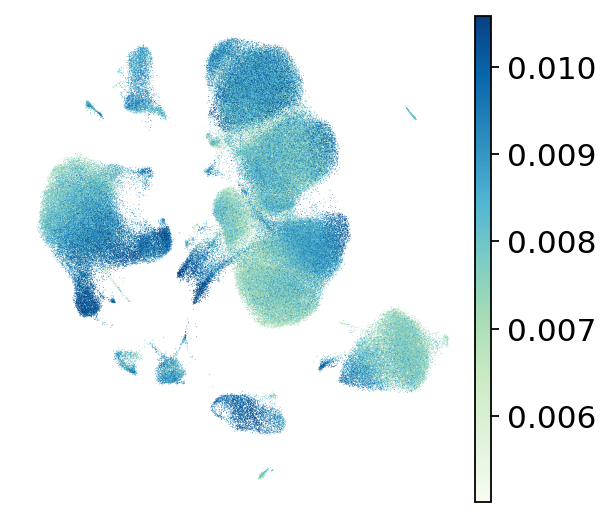

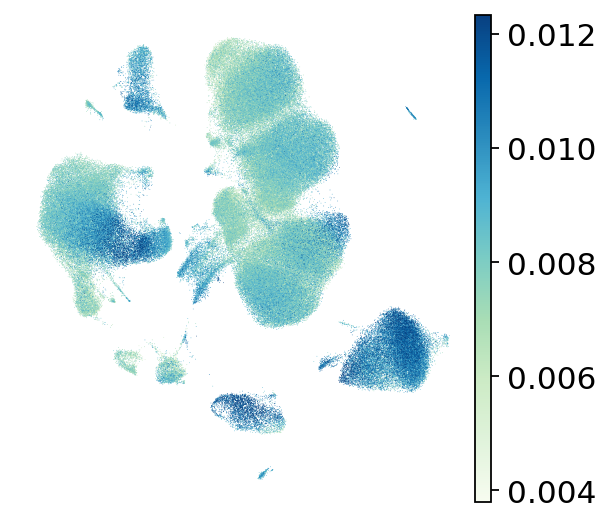

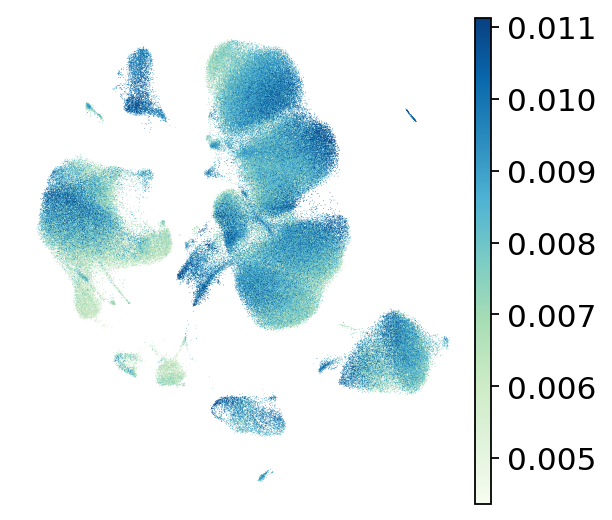

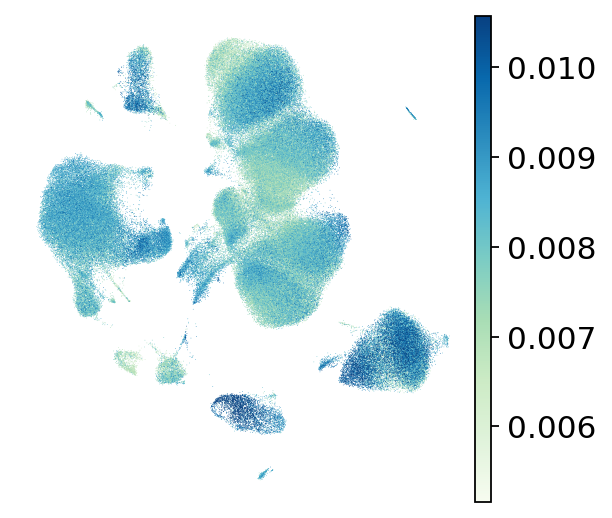

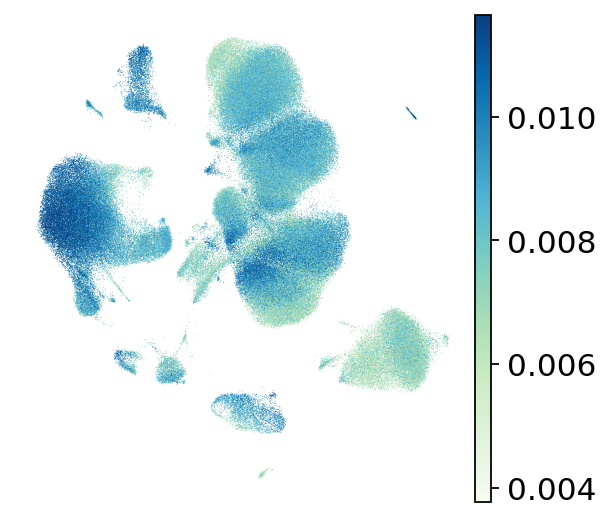

In [5]:
for i in range(5):
    sc.pl.umap(
        adata,
        color=[f'cell_attn_{i}'],
        frameon=False,
        ncols=1,
        #palette=colors,
        color_map="GnBu",
        title='',
        legend_loc=None,
        vmax='p99',
        save=f'_pbmc_cell_attn_{i}_reg.svg'
)

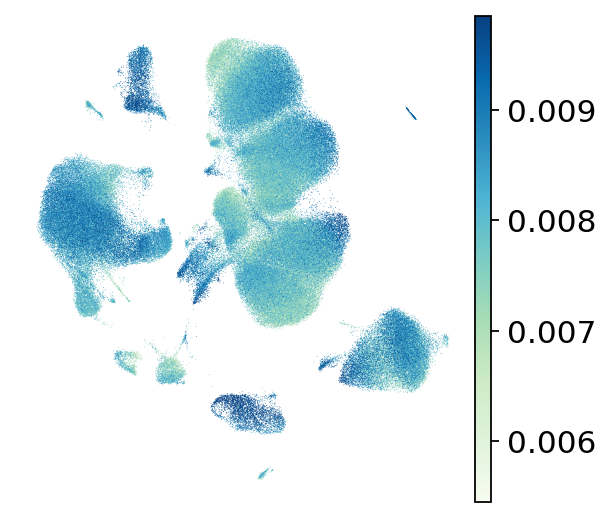

In [6]:
sc.pl.umap(
    adata,
    color=['cell_attn'],
    frameon=False,
    ncols=1,
    #palette=colors,
    color_map="GnBu",
    title='',
    legend_loc=None,
    vmax='p99',
    save='_pbmc_cell_attn_reg.svg'
)

In [7]:
dfs = []
for cond in np.unique(adata.obs['Status_on_day_collection_summary']):
    adata_tmp = adata[adata.obs['Status_on_day_collection_summary'] == cond].copy()
    threshold_idx = int(len(adata_tmp) * 0.9)
    threshold_value = sorted(adata_tmp.obs['cell_attn'])[threshold_idx]
    adata_tmp.obs['group'] = 'all cells'
    adata_tmp.obs.loc[adata_tmp.obs['cell_attn'] >= threshold_value, 'group'] = 'top 10% cells'
    adata.obs[f'top_cells_{cond}'] = False
    adata.obs.loc[adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs_names, f'top_cells_{cond}'] = True
    adata.obs[f'top_cells_{cond}'] = adata.obs[f'top_cells_{cond}'].astype('category')
    dfs.append(adata_tmp[adata_tmp.obs['group'] == 'top 10% cells'].obs[['initial_clustering', 'Status_on_day_collection_summary']])

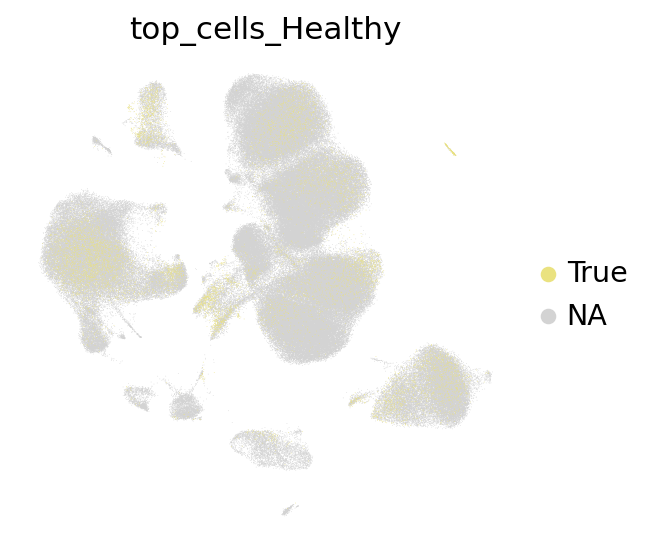

In [8]:
sc.pl.umap(
    adata,
    color=[f'top_cells_Healthy'],
    groups=[True],
    palette=['#EAE280'],
    frameon=False,
    save='_pbmc_top_healthy_reg.svg'
)

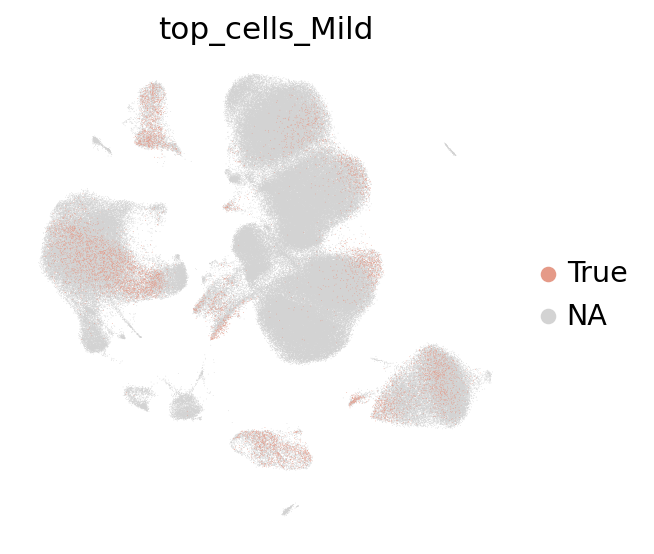

In [9]:
sc.pl.umap(adata, color=[f'top_cells_Mild'], groups=[True], palette=['#E59A88'], frameon=False, 
           save='_pbmc_top_mild_reg.svg'
          )

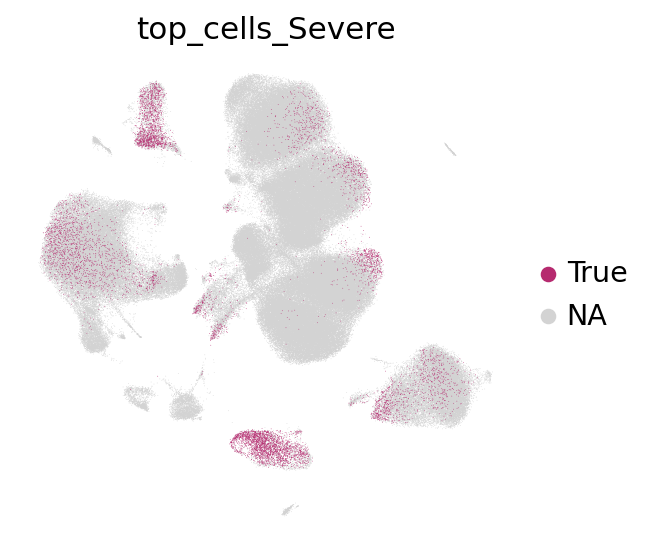

In [10]:
sc.pl.umap(adata, color=[f'top_cells_Severe'], groups=[True], palette=['#B62A6F'], frameon=False, 
           save='_pbmc_top_severe_reg.svg'
          )

### patient repr

In [11]:
adata.obs

,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,full_clustering,initial_clustering,Resample,Collection_Day,...,_scvi_batch,cell_attn_0,cell_attn_1,cell_attn_2,cell_attn_3,cell_attn_4,cell_attn,top_cells_Healthy,top_cells_Mild,top_cells_Severe
covid_index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGACCACGA-newcastle65,newcastle65,1351,1351,4278.0,178.0,4.160823,CD4.Naive,CD4,Initial,D0,...,0,0.006190,0.006770,0.008202,0.007753,0.007448,0.007273,False,False,False
AAACCTGAGATGTCGG-newcastle65,newcastle65,1921,1921,4740.0,127.0,2.679325,NK_16hi,NK_16hi,Initial,D0,...,0,0.007656,0.007866,0.008842,0.008213,0.007634,0.008042,False,False,False
AAACCTGAGGCGATAC-newcastle65,newcastle65,1056,1056,2875.0,198.0,6.886957,CD4.Naive,Treg,Initial,D0,...,0,0.006365,0.007434,0.007229,0.006852,0.008385,0.007253,False,False,False
AAACCTGAGTACACCT-newcastle65,newcastle65,2140,2140,5260.0,316.0,6.007605,NK_16hi,NK_16hi,Initial,D0,...,0,0.008148,0.006404,0.008215,0.007610,0.006395,0.007354,False,False,False
AAACCTGAGTGAATTG-newcastle65,newcastle65,1620,1620,4043.0,232.0,5.738313,CD8.EM,CD4,Initial,D0,...,0,0.008234,0.007257,0.008023,0.008149,0.007884,0.007909,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,BGCV15_CV0176,1631,1631,5325.0,184.0,3.455399,CD4.CM,CD4,Resample,D28,...,0,0.007471,0.007756,0.008066,0.007099,0.007767,0.007632,False,False,False
BGCV15_TTTGGTTTCAAGATCC-1,BGCV15_CV0944,2503,2503,6681.0,264.0,3.951504,NK_16hi,NK_16hi,Initial,D0,...,0,0.010297,0.008115,0.009406,0.008696,0.008806,0.009064,True,False,False
BGCV15_TTTGTCAAGGCGATAC-1,BGCV15_CV0176,2401,2401,8633.0,490.0,5.675895,CD4.CM,CD4,Resample,D28,...,0,0.006133,0.007272,0.006614,0.006128,0.006125,0.006454,False,False,False


In [12]:
tmp = adata

In [13]:
for i in range(tmp.X.shape[1]):
    tmp.obs[f'latent{i}'] = tmp.X[:, i].copy()
    tmp.obs[f'latent{i}_weighted'] = tmp.obs[f'latent{i}'] * tmp.obs['cell_attn']
tmp.obs[['latent0', 'latent0_weighted', 'cell_attn']]

,latent0,latent0_weighted,cell_attn
covid_index,,,
AAACCTGAGACCACGA-newcastle65,-0.170344,-0.001239,0.007273
AAACCTGAGATGTCGG-newcastle65,-1.007411,-0.008102,0.008042
AAACCTGAGGCGATAC-newcastle65,-0.251497,-0.001824,0.007253
AAACCTGAGTACACCT-newcastle65,-0.701973,-0.005163,0.007354
AAACCTGAGTGAATTG-newcastle65,-0.109289,-0.000864,0.007909
...,...,...,...
BGCV15_TTTGGTTGTTGGGACA-1,0.413836,0.003158,0.007632
BGCV15_TTTGGTTTCAAGATCC-1,-0.254439,-0.002306,0.009064
BGCV15_TTTGTCAAGGCGATAC-1,-0.605825,-0.003910,0.006454


In [14]:
df = tmp.obs[[f'latent{i}' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0,latent1,latent2,latent3,latent4,latent5,latent6,latent7,latent8,latent9,...,latent12,latent13,latent14,latent15,latent16,latent17,latent18,latent19,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,0.344548,-0.150528,0.306088,-0.187310,0.218147,-0.077847,0.230981,-0.208586,-0.254200,0.043318,...,0.047392,-0.403155,-0.187793,-0.164077,-0.282662,0.319426,-0.171868,-0.065580,Severe,Sanger
AP4,0.165106,-0.236559,0.614609,-0.148086,-0.038765,-0.132805,0.151039,-0.324218,-0.330311,-0.025014,...,-0.030480,-0.076111,-0.179940,-0.233890,-0.197369,0.096934,-0.378309,-0.326807,Mild,Sanger
AP5,0.413475,-0.663631,-0.038010,-0.501842,-0.212037,-0.038159,-0.037974,-0.089472,-0.399102,-0.011391,...,-0.117136,-0.107880,-0.293442,-0.190262,0.079365,-0.133489,0.218204,-0.356163,Severe,Sanger


In [15]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [16]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [17]:
loo = LeaveOneOut()

In [18]:
mean_train_accuracies = {}
mean_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    mean_train_accuracies[k] = train_accuracies
    mean_test_accuracies[k] = test_accuracies

In [19]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(mean_train_accuracies[k])))
    print(np.mean(np.array(mean_test_accuracies[k])))

k = 3:
0.7976190476190476
0.6122448979591837
k = 5:
0.7351190476190476
0.6326530612244898
k = 7:
0.6968537414965985
0.6530612244897959
k = 9:
0.71343537414966
0.6122448979591837


In [20]:
sc.pp.neighbors(pb)

In [21]:
sc.tl.umap(pb)

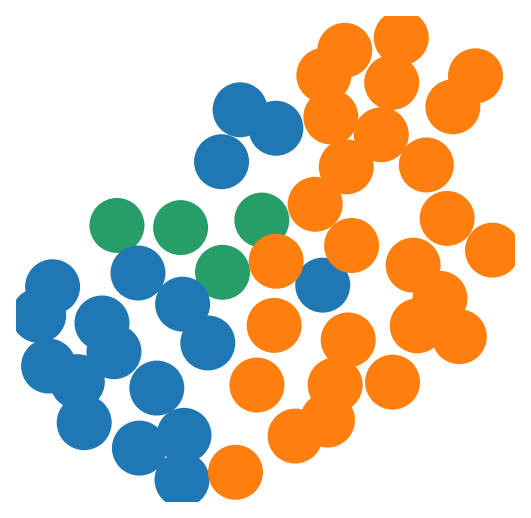

In [22]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_site.svg'
)

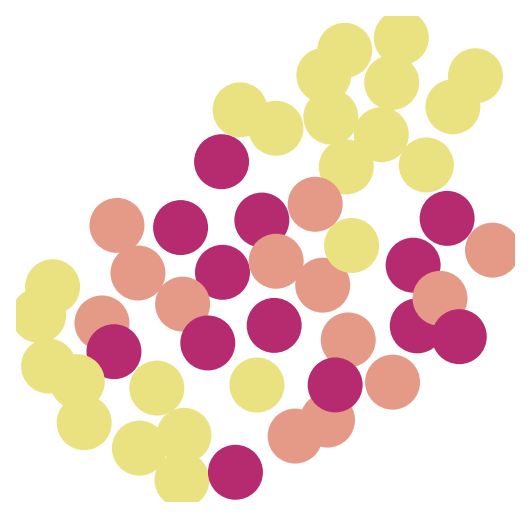

In [23]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_mean_reg.svg'
)

In [24]:
df = tmp.obs[[f'latent{i}_weighted' for i in range(tmp.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('sum')
df = df.join(tmp.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0_weighted,latent1_weighted,latent2_weighted,latent3_weighted,latent4_weighted,latent5_weighted,latent6_weighted,latent7_weighted,latent8_weighted,latent9_weighted,...,latent12_weighted,latent13_weighted,latent14_weighted,latent15_weighted,latent16_weighted,latent17_weighted,latent18_weighted,latent19_weighted,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,13.740811,-5.661835,7.750045,-6.971814,7.810901,-3.366172,8.530407,-6.313860,-9.201239,1.020032,...,-0.264271,-14.646567,-6.791525,-5.642820,-11.618423,11.312559,-6.167021,-1.145328,Severe,Sanger
AP4,11.709303,-14.714625,31.345430,-9.400415,-2.171533,-7.830876,9.409928,-18.494688,-19.868660,-2.320004,...,-4.849463,-4.820217,-9.583519,-14.095164,-14.801988,6.172076,-23.117596,-18.754860,Mild,Sanger
AP5,29.494465,-44.741051,-5.238051,-34.582222,-15.075027,-4.256617,-2.755678,-4.513967,-27.387459,-1.616074,...,-10.825323,-8.575839,-19.173697,-11.256024,4.286177,-8.718843,15.617206,-22.615652,Severe,Sanger


In [25]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [26]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [27]:
loo = LeaveOneOut()

In [28]:
attn_train_accuracies = {}
attn_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    attn_train_accuracies[k] = train_accuracies
    attn_test_accuracies[k] = test_accuracies

In [29]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(attn_train_accuracies[k])))
    print(np.mean(np.array(attn_test_accuracies[k])))

k = 3:
0.7657312925170069
0.5918367346938775
k = 5:
0.7074829931972788
0.5918367346938775
k = 7:
0.6585884353741497
0.5918367346938775
k = 9:
0.6662414965986395
0.5714285714285714


In [30]:
sc.pp.neighbors(pb)

In [31]:
sc.tl.umap(pb)

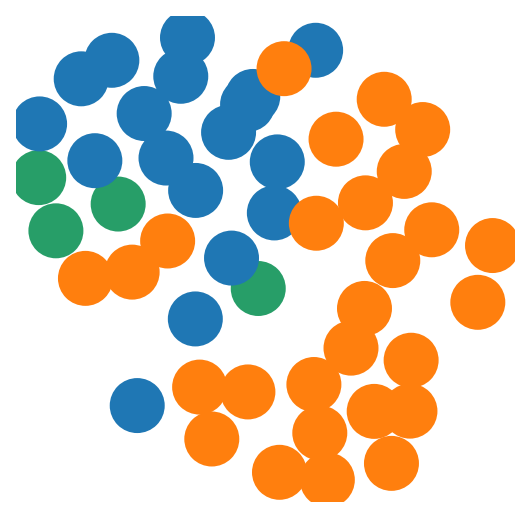

In [32]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_weighted_site.svg'
)

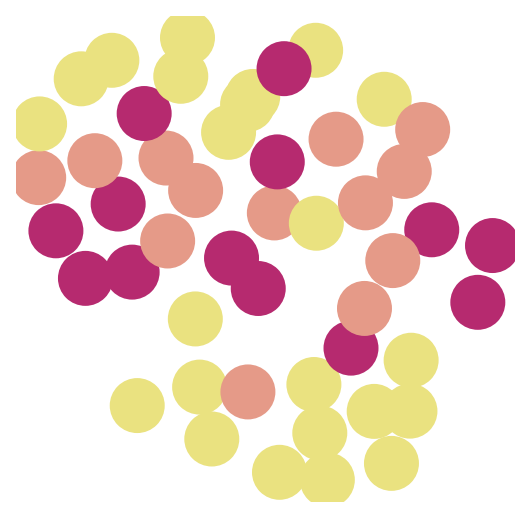

In [33]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_attn_weighted_reg.svg'
)

In [34]:
df1 = pd.DataFrame(attn_test_accuracies)
df2 = pd.DataFrame(mean_test_accuracies)

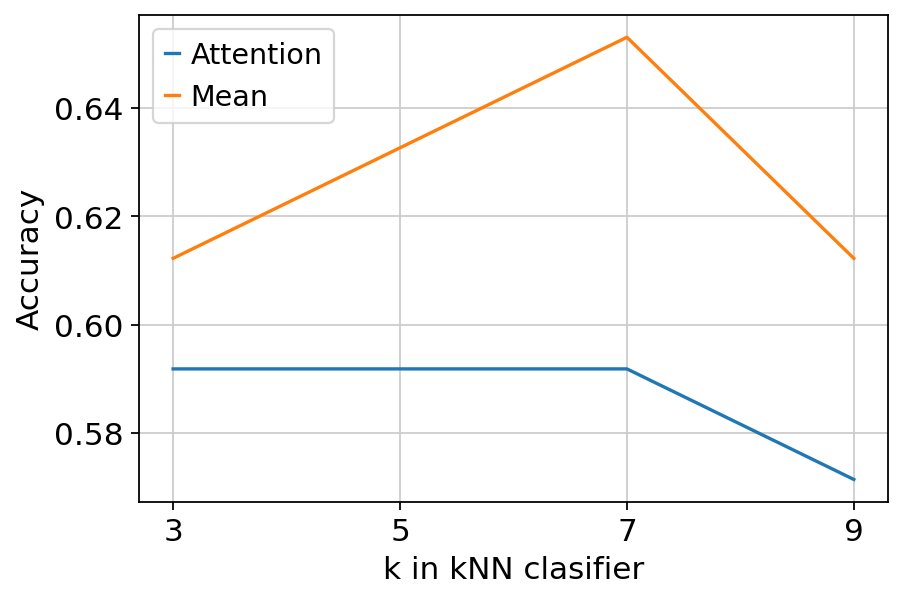

In [35]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
plt.plot(df1.mean().index.astype(str).values, df1.mean().values, label='Attention')
plt.plot(df2.mean().index.astype(str).values, df2.mean().values, label='Mean')
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('figures/mil_knn_classifier.svg', bbox_inches='tight')

In [36]:
adata_top = adata[(adata.obs['top_cells_Healthy'] == True) | (adata.obs['top_cells_Mild'] == True) | (adata.obs['top_cells_Severe'] == True)].copy()
adata_top

AnnData object with n_obs × n_vars = 25606 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_Healthy', 'top_cells_Mild', 'top_cells_Severe', 'latent0', 'latent0_weighted', 'latent1', 'latent1_weighted', 'latent2', 'latent2_weighted', 'latent3', 'latent3_weighted', 'latent4', 'latent4_weighted', 'latent5', 'latent5_weighted', 'latent6', 'latent6_weighted', 'latent7', 'latent7_weighted', 'latent8', 'latent8_weighted', 'latent9', 'latent9_weighted', 'latent10',

In [37]:
tmp_top = adata_top

In [38]:
for i in range(adata_top.X.shape[1]):
    tmp_top.obs[f'latent{i}'] = tmp_top.X[:, i].copy()

In [39]:
df = tmp_top.obs[[f'latent{i}' for i in range(tmp_top.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
df = df.join(tmp_top.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
df[:3]

,latent0,latent1,latent2,latent3,latent4,latent5,latent6,latent7,latent8,latent9,...,latent12,latent13,latent14,latent15,latent16,latent17,latent18,latent19,Status_on_day_collection_summary,Site
patient_id,,,,,,,,,,,,,,,,,,,,,
AP1,1.291707,-0.394724,-0.834823,-0.392998,0.223008,-0.490855,0.442340,0.136701,-0.384264,-0.162783,...,-0.854757,-0.788346,-0.356110,-0.118752,-1.062592,0.248522,-0.179787,0.362400,Severe,Sanger
AP4,1.090731,-0.581662,-0.798496,-0.333804,-0.029359,-0.175334,0.551576,-0.281543,-0.509858,-0.213870,...,-1.015629,-0.305094,0.049396,-0.524127,-1.613697,0.246568,-0.781505,-0.256935,Mild,Sanger
AP5,1.197176,-0.759558,-0.561892,-1.075815,-0.707831,-1.311540,-0.029961,0.608275,-0.922136,-0.165369,...,-0.992661,-0.971695,-0.286003,0.651971,-0.373664,-0.051080,0.565279,-0.008764,Severe,Sanger


In [40]:
pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
pb.obs = df[['Status_on_day_collection_summary', 'Site']]
pb

AnnData object with n_obs × n_vars = 49 × 20
    obs: 'Status_on_day_collection_summary', 'Site'

In [41]:
X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
y = df[['Status_on_day_collection_summary']].values.ravel()

In [42]:
loo = LeaveOneOut()

In [43]:
top_train_accuracies = {}
top_test_accuracies = {}
for k in [3, 5, 7, 9]:
    train_accuracies = []
    test_accuracies = []
    for i, (train_index, test_index) in enumerate(loo.split(X)):
        knn = KNeighborsClassifier(n_neighbors = k)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        knn.fit(X_train, y_train)
        y_train_predict = knn.predict(X_train)
        y_test_predict = knn.predict(X_test)
        train_accuracies.append(np.mean(y_train_predict == y_train))
        test_accuracies.append(np.mean(y_test_predict == y_test))
    top_train_accuracies[k] = train_accuracies
    top_test_accuracies[k] = test_accuracies

In [44]:
for k in [3, 5, 7, 9]:
    print(f'k = {k}:')
    print(np.mean(np.array(top_train_accuracies[k])))
    print(np.mean(np.array(top_test_accuracies[k])))

k = 3:
0.858843537414966
0.7346938775510204
k = 5:
0.8562925170068028
0.6938775510204082
k = 7:
0.8235544217687074
0.6938775510204082
k = 9:
0.767857142857143
0.5918367346938775


In [45]:
sc.pp.neighbors(pb)

In [46]:
sc.tl.umap(pb)

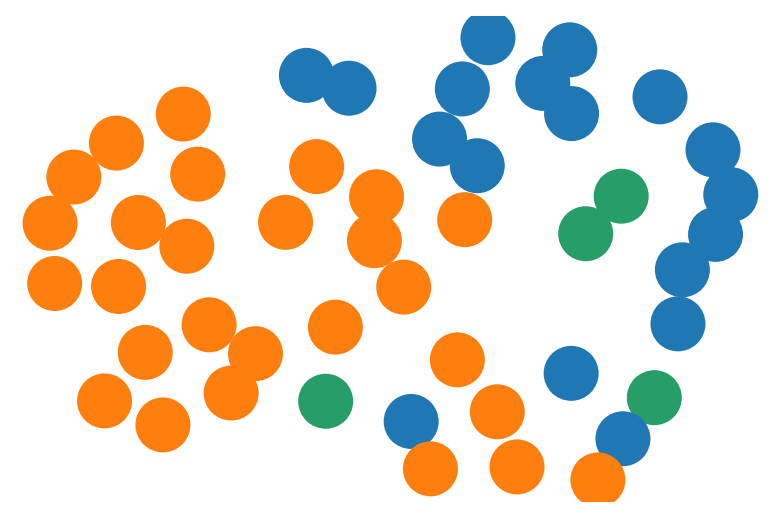

In [47]:
sc.pl.umap(
    pb,
    color=['Site'],
    frameon=False,
    title='',
    legend_loc=None,
    #palette=['#EAE280', '#E59A88', '#B62A6F'],
    #save='_pbmc_patient_repr_site.svg'
)

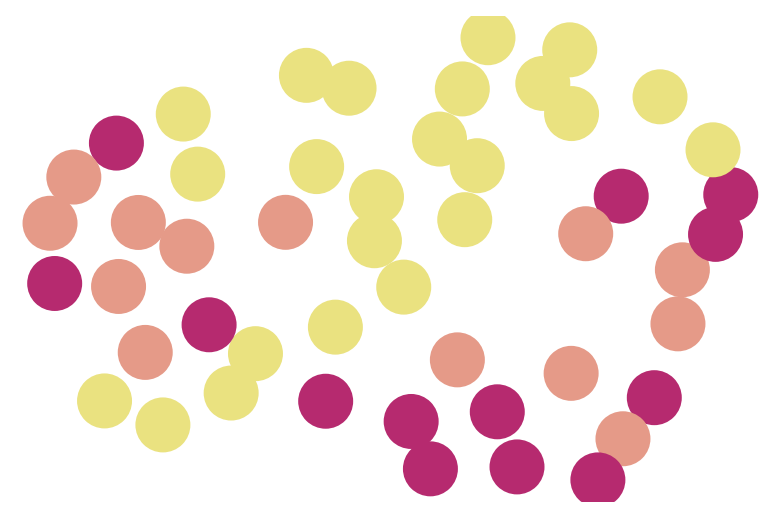

In [48]:
sc.pl.umap(
    pb,
    color=['Status_on_day_collection_summary'],
    frameon=False,
    title='',
    legend_loc=None,
    palette=['#EAE280', '#E59A88', '#B62A6F'],
    save='_pbmc_patient_repr_top10perc_reg.svg'
)

In [49]:
df3 = pd.DataFrame(top_test_accuracies)

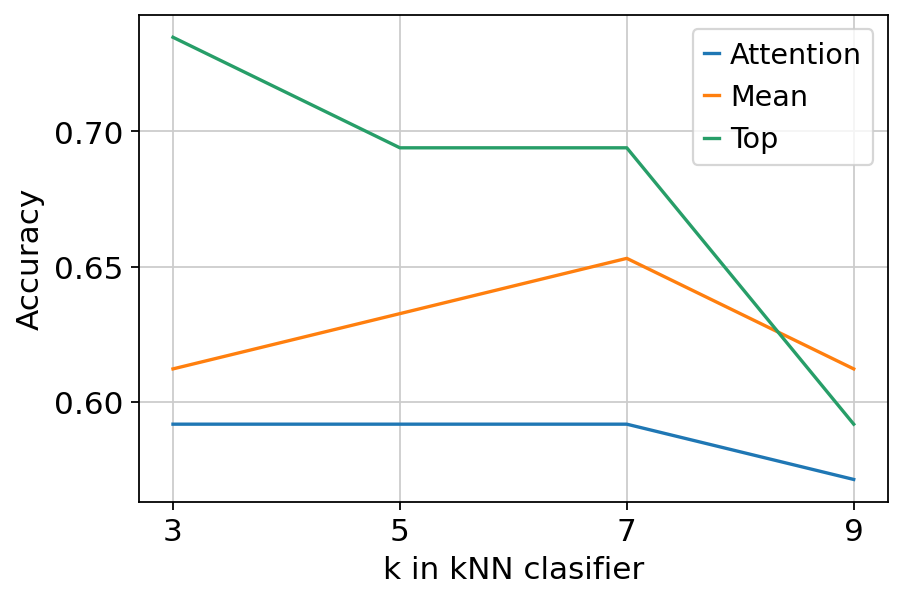

In [50]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
plt.plot(df1.mean().index.astype(str).values, df1.mean().values, label='Attention')
plt.plot(df2.mean().index.astype(str).values, df2.mean().values, label='Mean')
plt.plot(df3.mean().index.astype(str).values, df3.mean().values, label='Top')
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mil_knn_classifier_reg.svg', bbox_inches='tight')

In [51]:
adata

AnnData object with n_obs × n_vars = 256051 × 20
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', 'cell_attn_0', 'cell_attn_1', 'cell_attn_2', 'cell_attn_3', 'cell_attn_4', 'cell_attn', 'top_cells_Healthy', 'top_cells_Mild', 'top_cells_Severe', 'latent0', 'latent0_weighted', 'latent1', 'latent1_weighted', 'latent2', 'latent2_weighted', 'latent3', 'latent3_weighted', 'latent4', 'latent4_weighted', 'latent5', 'latent5_weighted', 'latent6', 'latent6_weighted', 'latent7', 'latent7_weighted', 'latent8', 'latent8_weighted', 'latent9', 'latent9_weighted', 'latent10'

In [52]:
dfs = {}
for top_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    threshold_idx = int(len(adata) * top_percentage)
    threshold_value = sorted(adata.obs['cell_attn'])[threshold_idx]
    adata_top = adata[adata.obs['cell_attn'] >= threshold_value].copy()
    for i in range(adata_top.X.shape[1]):
        adata_top.obs[f'latent{i}'] = adata_top.X[:, i].copy()
    df = adata_top.obs[[f'latent{i}' for i in range(adata_top.X.shape[1])] + ['patient_id']].groupby('patient_id').agg('mean')
    df = df.join(adata_top.obs[['patient_id', 'Status_on_day_collection_summary', 'Site']].groupby('patient_id').agg('first'))
    pb = sc.AnnData(df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values)
    pb.obs = df[['Status_on_day_collection_summary', 'Site']]
    X = df.drop(['Status_on_day_collection_summary', 'Site'], axis=1).values
    y = df[['Status_on_day_collection_summary']].values.ravel()
    loo = LeaveOneOut()
    top_train_accuracies = {}
    top_test_accuracies = {}
    for k in [3, 5, 7, 9]:
        train_accuracies = []
        test_accuracies = []
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            knn = KNeighborsClassifier(n_neighbors = k)
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            knn.fit(X_train, y_train)
            y_train_predict = knn.predict(X_train)
            y_test_predict = knn.predict(X_test)
            train_accuracies.append(np.mean(y_train_predict == y_train))
            test_accuracies.append(np.mean(y_test_predict == y_test))
        # top_train_accuracies[k] = train_accuracies
        top_test_accuracies[k] = test_accuracies
    dfs[top_percentage] = pd.DataFrame(top_test_accuracies)

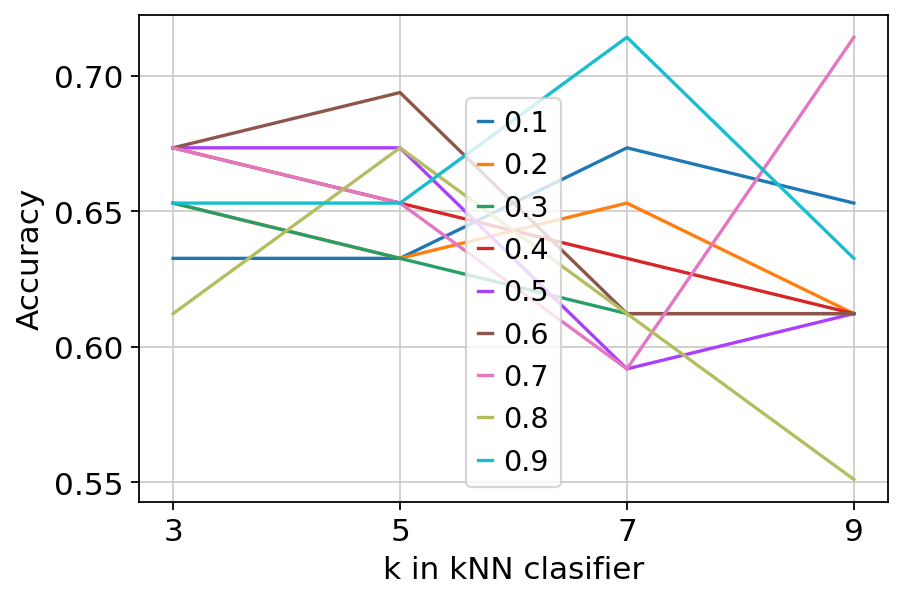

In [53]:
sc.set_figure_params(vector_friendly=True, figsize=(6,4))
for top_percentage in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    plt.plot(dfs[top_percentage].mean().index.astype(str).values, dfs[top_percentage].mean().values, label=top_percentage)
plt.xlabel('k in kNN clasifier')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('figures/mil_knn_classifier_top_reg.svg', bbox_inches='tight')